In [1]:
# Setup
checkpoints_path = '/Users/alukasik/Documents/IDEO/Developer/checkpoints/chairs-30-5-18/checkpoint.ckpt'
batch_size = 64 # must match batch size of saved session
img_shape = (256, 256)
zsize = 16 # number of variables for "genome"

In [2]:
# imports

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import math


from utils import pixels01, pixels11
from model import Model as M

/anaconda3/envs/chairs/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [64]:
savechair = []
incorrectchair = []

In [4]:
def imshow(imgs, cols=4):
    fig = plt.figure(figsize=(15,8))
    nimgs = len(imgs)
    rows = math.ceil(float(nimgs)/cols) 
    row = 0
    for i in range(nimgs):
        a=fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

In [5]:
model = M(None, batch_size=batch_size, img_shape=img_shape, checkpoints_path=checkpoints_path, zsize=zsize)

model.build_model()
model.setup_session()

trying to restore session from /Users/alukasik/Documents/IDEO/Developer/checkpoints/chairs-30-5-18/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from /Users/alukasik/Documents/IDEO/Developer/checkpoints/chairs-30-5-18/checkpoint.ckpt
restored session


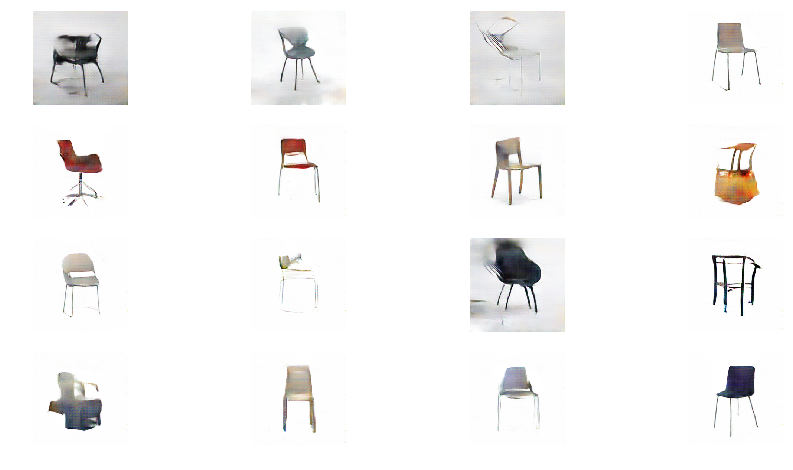

In [125]:
zdraw = np.random.normal(scale=1.0, size=(batch_size, 16)).astype('float32')
imgs = pixels01(model.Gz.eval({ model.Z: zdraw, model.is_training: False }))
imshow(imgs[:16])

In [127]:
savechair.append(zdraw[14,:])

In [130]:
incorrectchair.append(zdraw[11,:])

In [58]:
# savechair = []

In [9]:
# diskchairs = np.loadtxt("chairs.csv", delimiter=",")

In [ ]:
zdraw[0] = (zdraw[2] + zdraw[5]) / 2
#addition of the the 2nd image and 5th image
imgs = pixels01(model.Gz.eval({ model.Z: zdraw, model.is_training: False }))
imshow(imgs[:8])

In [ ]:
zdraw[0] = -zdraw[5]
imgs = pixels01(model.Gz.eval({ model.Z: zdraw, model.is_training: False }))
imshow(imgs[:8])


In [ ]:
imshow(imgs[17:24])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


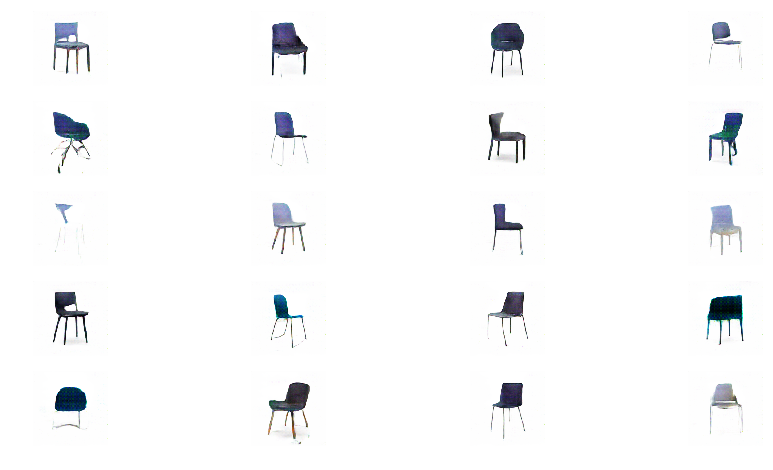

In [128]:
imgs = pixels01(model.Gz.eval({ model.Z: savechair, model.is_training: False }))
imshow(imgs[:100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


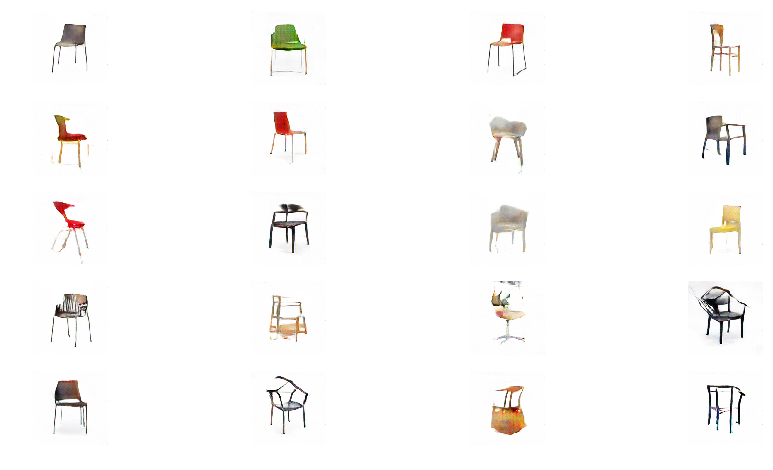

In [131]:
imgs = pixels01(model.Gz.eval({ model.Z: incorrectchair, model.is_training: False }))
imshow(imgs[:100])

In [ ]:
n_interps = 12
delta = (savechair[1] - savechair[0]) / n_interps
interpolated = np.zeros((n_interps+1, 128))
interpolated[0,:] = savechair[0]
for i in range(n_interps-1):
    interpolated[i+1,:] = interpolated[i,:] + delta


interpolated[-1,:] = savechair[1]

In [ ]:
imgs = pixels01(model.Gz.eval({ model.Z: interpolated, model.is_training: False }))
imshow(imgs[:12])

In [ ]:
varied = savechair[1] + np.random.normal(scale=0.6, size=(8, 128)).astype('float32')
varied[0,1] = 0
imgs = pixels01(model.Gz.eval({ model.Z: varied, model.is_training: False }))
imshow(imgs[:12])

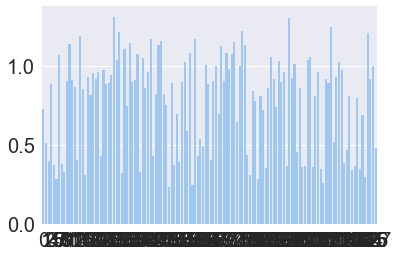

In [68]:
savechairmatrix = np.array(savechair)
savechairmatrix.shape
stds = np.std(savechairmatrix, axis=0)

sns.set_style("white")
sns.set_color_codes("pastel")
sns.set(font_scale=2)

labels = list(range(stds.size))

sns.barplot(x=labels, y=stds, color="b")
sns.despine()

In [69]:
indices = np.where(stds < 0.7)
indices

(array([  1,   2,   4,   5,   7,   8,  13,  16,  22,  30,  37,  42,  48,
         50,  51,  52,  55,  57,  59,  60,  61,  64,  67,  74,  78,  79,
         82,  85,  93,  97,  99, 100, 103, 106, 107, 111, 115, 116, 118,
        119, 121, 122, 123, 127]),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


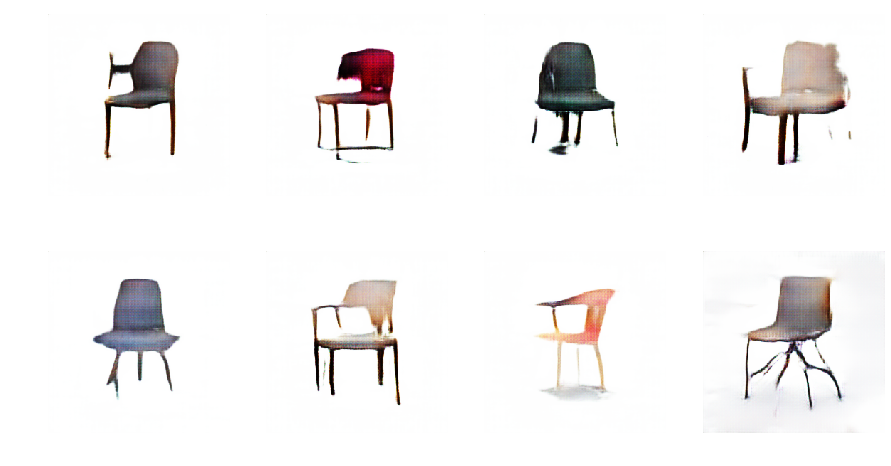

In [70]:
biased_zdraw = np.random.normal(scale=1.0, size=(batch_size, 128)).astype('float32')
_savechair = np.array(savechair)
for i in np.nditer(indices):
    biased_zdraw[:,i] = _savechair[0,i]

imgs = pixels01(model.Gz.eval({ model.Z: biased_zdraw, model.is_training: False }))
imshow(imgs[:8])


In [66]:
savechair.append(biased_zdraw[2,:])

In [133]:
# np.savetxt("nochairs.csv", savechair, delimiter=",")

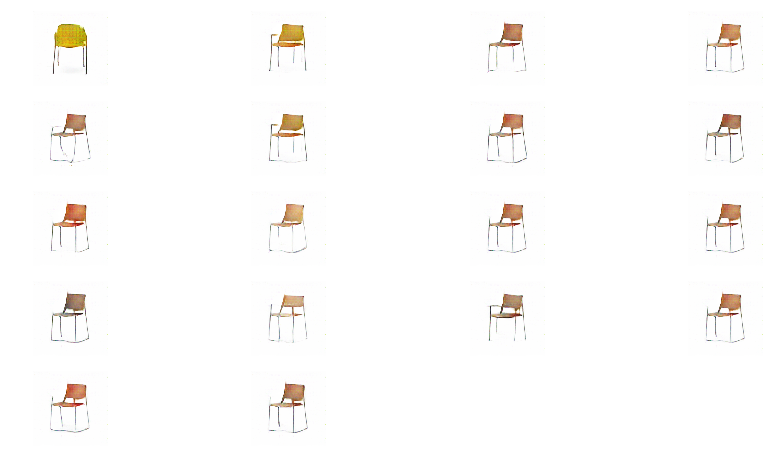

In [57]:
for i in range(zsize):
    diffchair = np.array(masterchair[0])
    diffchair[i] = 0
    savechair.append(diffchair)

imgs = pixels01(model.Gz.eval({ model.Z: savechair, model.is_training: False }))
imshow(imgs[:100])

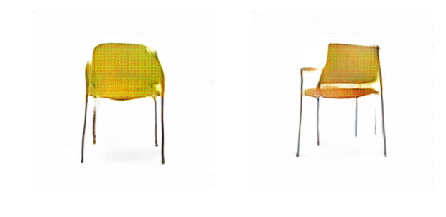

In [56]:
diffchair = np.array(masterchair[0])
diffchair[3] = 0
diffchair[6] = 0
savechair.append(diffchair)

imgs = pixels01(model.Gz.eval({ model.Z: savechair, model.is_training: False }))
imshow(imgs[:100])

In [48]:
# masterchair = []
# masterchair.append(savechair[2])